In [1]:
import os
import rootutils
import torch
import torchvision.transforms as transforms
from pathlib import Path
import cv2
import numpy as np
from IPython.display import display
from PIL import Image

root_dir = os.path.abspath("..")
rootutils.setup_root(root_dir, indicator=[".git", "pyproject.toml"], pythonpath=True)

from src.models.components.cnn_cam_multihead import CNNCAMMultihead
from src.models.components.vit_rollout_multihead import VitRolloutMultihead

c:\Users\lukas\anaconda3\envs\DeepVisionXplain\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
def weight_load(
    ckpt_path: str, ext: str = ".pth"
) -> dict:
    """Model weight loading helper function.

    Args:
        ckpt_path (str): Path of the weights.
        ext (str, optional): Checkpoint extension. Defaults to ".ckpt".

    Returns:
        dict: Model weights.
    """
    if not ckpt_path.endswith(ext):
        searched_path = Path(ckpt_path)
        ckpt_path = next(searched_path.rglob("*" + ext), "")

    model_weights = torch.load(ckpt_path)

    return model_weights

In [4]:
def apply_cm(
    image: np.array, map: np.array
) -> None:
    """Image saving function for image, explainability map and label. Images are
    horizontally concatenated.

    Args:
        image (np.array): Original image.
        map (np.array): Explainability map.
    """
    # Thresholded map
    map_thresholded = np.where(map > 0.5, 1, 0)
    map_thresholded = (map_thresholded * 255).astype(np.uint8)
    map_thresholded = cv2.cvtColor(map_thresholded, cv2.COLOR_GRAY2RGB)

    # Normalize map for applying colormap
    map_normalized = cv2.normalize(
        map, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U
    )
    # Apply the JET colormap
    map_colored = cv2.applyColorMap(map_normalized, cv2.COLORMAP_JET)

    alpha = 0.5  # Transparency for the map overlay
    blended_image = cv2.addWeighted(image, 1 - alpha, map_colored, alpha, 0)

    return blended_image

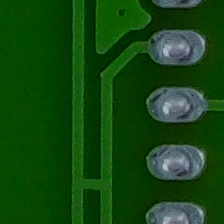

In [5]:
image = cv2.imread("../docs/sample_data/01_short_04_1926_1070.png", cv2.IMREAD_COLOR)
display(Image.fromarray(image))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

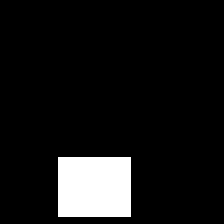

In [6]:
label = cv2.imread("../docs/sample_data/01_short_04_1926_1070_label.png", cv2.IMREAD_COLOR)
display(Image.fromarray(label))

In [7]:
transform = transforms.Compose([
    transforms.ToTensor()
])
image_tensor = transform(image).unsqueeze(0).to(device)

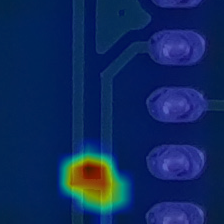

In [8]:
cnn_model = CNNCAMMultihead(
    backbone = "torchvision.models/efficientnet_v2_s",
    return_node="features.6.0.block.0",
    multi_head=True
).to(device)

weights = weight_load(ckpt_path="../trained_models/models--DeepVisionXplain--efficientnet_v2_s_downscaled_pcb/")

cnn_model.load_state_dict(weights)
cnn_model.eval()
with torch.no_grad():
    out, cam = cnn_model(image_tensor)

preds = (out > 0.5).float()
for i, pred in enumerate(preds):
    map_segmentation = cam[i] if pred == 1 else torch.zeros_like(cam[i])
    if pred == 1:
        map_segmentation = (map_segmentation - map_segmentation.min()) / (map_segmentation.max() - map_segmentation.min())
    map_segmentation = map_segmentation.cpu().numpy()
    blended_img = apply_cm(image, map_segmentation)

    # Only for displaying
    blended_img = cv2.cvtColor(blended_img, cv2.COLOR_BGR2RGB)
    display(Image.fromarray(blended_img))

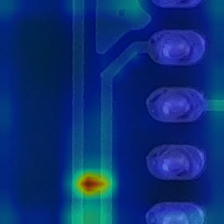

In [9]:
vit_model = VitRolloutMultihead(
    backbone = "timm/vit_tiny_patch16_224.augreg_in21k_ft_in1k",
    multi_head=True
).to(device)

weights = weight_load(ckpt_path="../trained_models/models--DeepVisionXplain--deit_tiny_patch16_224.fb_in1k_pcb/")

vit_model.load_state_dict(weights)
vit_model.eval()
with torch.no_grad():
    out, cam = vit_model(image_tensor)

preds = (out > 0.5).float()
for i, pred in enumerate(preds):
    map_segmentation = cam[i] if pred == 1 else torch.zeros_like(cam[i])
    if pred == 1:
        map_segmentation = (map_segmentation - map_segmentation.min()) / (map_segmentation.max() - map_segmentation.min())
    map_segmentation = map_segmentation.cpu().numpy()
    blended_img = apply_cm(image, map_segmentation)

    # Only for displaying
    blended_img = cv2.cvtColor(blended_img, cv2.COLOR_BGR2RGB)
    display(Image.fromarray(blended_img))